In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from __future__ import division
%matplotlib inline

# Tutorial 2: State space models and filtering

## Introduction

In this tutorial we will generate data from a linear-Gaussian state space model (LG-SSM), and solve it by different exact and approximate methods. Then we'll introduce a hierarchical model (a "Double Kalman Filter"), a model that was used a.o. in Behrens et al. 2007 to model how people assess volatility in their environment and adjust reward-based decisions accordingly. You've seen this paper referenced in several talks during the summer school (some of you even collected data using a similar model), and this tutorial will give you an opportunity to learn to fit the data using the actual (or assumed) generative model.

SSMs are a continuous version of Hidden Markov Models, sharing the same graphical model structure.

<img src="SSM.png">

This class of models has many practical applications in modeling sequential temporal events (e.g. the location of a moving object in tracking applications such as GPU), as well as modeling other sequential data e.g. sequences of words in language modeling, or genes in models for computational biology. In neuroscience it has been used to model navigation, motor control, reward learning, and a range of other phenomena.

We will try to make inferences about the hidden state variables $z_{1:t}$, given the noisy observations $x_{i:t}$, a process called state estimation. We will assume that both the transition model $p(z_t |z_{t-1})$ and the observation model $p(x_t |z_{t})$ are known, and Gaussian.

\begin{eqnarray}
z_t=A \cdot z_{t-1}+\epsilon \\
x_t=B \cdot z_{t}+\delta\\
z_1 \sim \mathcal{N}(0, \sigma_1^{2}) \\
\epsilon \sim \mathcal{N}(0, \sigma_z^{2}). \\
\delta \sim \mathcal{N}(0, \sigma_x^{2}). 
\end{eqnarray}



## Exercise 1
Write a function to generate data from a 1D LG-SSM (where both z and x are scalars). The function should take the standard deviations $\sigma_z$ and $\sigma_x$ as inputs, as well as the number of steps,and a prior mean for $z_1$. It should return a vector of $z$-s and $x$-s. For simplicity, we will assume that the prior and transition variances are the same, $\sigma_1^{2}=\sigma_z^{2}$.

Test the function by generating data from a SSM with $\sigma_z=0.3$, $\sigma_x=1.2$  and  $E(Z)=0$ for 100 timesteps, and make a plot showing the evolution of z and x over time, with the observations $x_{1:t}$ scattered around the line $z_{1:t}$.

<img src="SSM_fig_3.png">

In [110]:
def lg_ssm(sigma_z = 0.3, sigma_x = 1.2, nsteps = 100, mu_z = 0, A = 1, B = 1):
    z = np.random.normal(loc = mu_z)
    Z, X = np.zeros(nsteps), np.zeros(nsteps)
    for t in range(nsteps):
        z = A * z + sigma_z * np.random.randn()
        x = B * z + sigma_x * np.random.randn()
        Z[t], X[t] = z, x
    return range(nsteps), Z, X

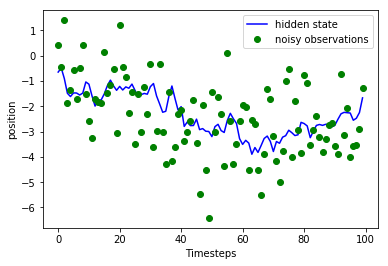

In [111]:
t, Z, X = lg_ssm()
plt.plot(t, Z, "b", label = "hidden state")
plt.plot(t, X, "go", label = "noisy observations")
plt.xlabel("Timesteps")
plt.ylabel("position")
plt.legend()
plt.show()


We will now try to estimate the true hidden sequence z, given the noisy observations x, using Bayesian inference. We will do this online, estimating $z_t$ for every time step t, given the observations available at that time, $x_{1:t}$. a process called filtering. It is also possible to estimate the most likely sequence $z_t$ given all the observations (a method called smoothing), but we will leave this for now.

In our first approach, we will proceed by discretizing the domains of Z and X, and try to represent the posterior probability distribution over z by a series of probability masses over these discrete values.

## Exercise 2
First, derive an update rule for the probability distribution $p(z_t)$, given the posterior from the previous step, $p(z_{t-1})$, and the observation at time t, $x_t$.

Then write a function that performs one step of the filtering, taking as input the previous posterior $p(z_{t-1})$, the observation $x_t$, as well as $\sigma_z$ and $\sigma_x$, and returning the posterior $p(z)$, and a maximum likelihood estimate for $z_t$ (such as the MAP estimate, or posterior mean). Probability distributions should be represented by a vector of point masses over the discretized range. The upper and lower bounds of the descritization can be declared  as global variables with values 10 and -10 respectively.

In [5]:
def onestep_filter(pz, zs, x, sigma_z = 0.3, sigma_x = 1.2, A = 1, B = 1):
    p_x_z = stats.norm.pdf(x - B * zs, scale = sigma_x)
    p_z_t_z_t_1 = stats.norm.pdf(np.reshape(zs, (-1, 1)), - np.reshape(A * zs, (1, -1)), scale = sigma_z)
    pz = np.dot(p_z_t_z_t_1, pz) * p_x_z
    pz = pz / sum(pz)
    z_map = zs[np.argmax(pz)]
    return pz, z_map

Finally write a function that iterates over all the observations, performing the whole filtering process. Then call this function, and try to estimate the hidden states for the process you generated before, using the observations. Be careful to match the prior for $z_1$ in the estimation process to the one used in the generative model. Experiment with different discretizations, to see how many points you have to use in the interval to get a good result and produce some plots comparing your estimates for $z_t$ with the ground truth. Compare your state estimates to that obtained if you simply averaged over the observations with a sliding time window.

<img src="SSM_fig_4.png">

In [11]:
def nstep_filter(X, N = 100):
#     pz = np.zeros(N)
#     pz[len(pz)//2] = 1
    pz = np.ones(N) /  N
    zs = np.linspace(-10, 10, N)
    Z = np.zeros_like(X)
    for (t, x) in enumerate(X):
        pz, z_map = onestep_filter(pz, zs, x)
        Z[t] = z_map
    return Z

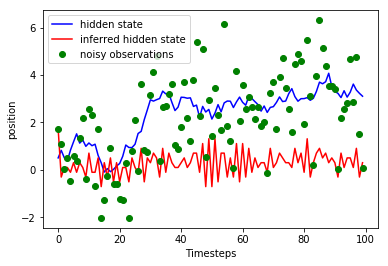

In [37]:
t, Z, X = lg_ssm()
Z_infer = nstep_filter(X, N = 100)
plt.plot(t, Z, "b", label = "hidden state")
plt.plot(t, Z_infer, "r", label = "inferred hidden state")
plt.plot(t, X, "go", label = "noisy observations")
plt.xlabel("Timesteps")
plt.ylabel("position")
plt.legend()
plt.show()

The above approach is not feasible in general, in particular where z and x are high dimensional variables. The number of points needed to tile the respective domains grows exponentially with the dimensionality of these variables, making the computational cost of this approach prohibitive, and the accuracy insufficient. This is an issue we already encountered with PPCs.

Luckily, in the linear-Gaussian case it is possible to calculate the exact posterior for $z_t$, since the Gaussian distribution is self-conjugate. This means that the posterior over $z_t$ will always be Gaussian, as long as the prior for z and the generative model are given by Gaussians. We will also implement this using our 1d example, with $A=B=1$, in which case the equations for the solution are:
\begin{eqnarray}
\\
\mu_{z_t}=\mu_{z_{t-1}}+K_t*(x_t-\mu_{z_{t-1}})\\
\\
\sigma_{z_t}^2=\sigma_x^2*K_t\\
\\
K_t=\frac{\sigma_z^2+\sigma_{z_{t-1}}^2}{\sigma_z^2+\sigma_{z_{t-1}}^2+\sigma_y^2\\}
\end{eqnarray}

where $K_t$ is the Kalman gain at time t. This first equation is similar to error driven learning rules you've already seen, except instead of a learning rate we now use the Kalman gain, to trade off uncertainty about the measurement and the observation in an optimal way. This method is known as the Kalman filter.

## Exercise 3

Write a function that computes one step of the analytical solution to the Kalman filter. The inputs should be the prior mean and variance of z, an observation, and the known standard deviations of the generative process as before, and the function should output the posterior mean and variance.

Then write a function that performs the filtering over the whole sequence of observations, and finally estimate the sequence $z_t$ for the process you used in the previous exercises. Compare your solutions to those from Ex.2





In [102]:
def onestep_filter(mu, sigma, K, x, sigma_z = 0.3, sigma_x = 1.2):
    mu = mu + K * (x - mu)
    sigma, K = sigma_x * np.sqrt(K), (sigma_z**2 + sigma**2) / (sigma_z**2 + sigma**2 + sigma_x**2)
    return mu, sigma, K

In [103]:
def nstep_filter(X, sigma_z = 0.3, sigma_x = 1.2):
    mu, sigma, K = 0, sigma_z, 1
    Z, S = np.zeros_like(X), np.zeros_like(X)
    for (t, x) in enumerate(X):
        mu, sigma, K = onestep_filter(mu, sigma, K, x)
        Z[t], S[t] = mu, sigma
    return Z, S

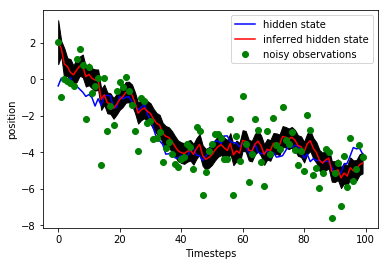

In [104]:
t, Z, X = lg_ssm()
Z_infer, S_infer = nstep_filter(X)

plt.plot(t, Z, "b", label = "hidden state")
plt.plot(t, Z_infer, "r", label = "inferred hidden state")
plt.fill_between(t, Z_infer - S_infer, Z_infer + S_infer, color = "black")
plt.plot(t, X, "go", label = "noisy observations")
plt.xlabel("Timesteps")
plt.ylabel("position")
plt.legend()
plt.show()

As mentioned above, the exact approach requires all the distributions specifying the generative model to be Gaussian, in which case the posterior is also Gaussian, and fully specified by a mean and variance. When this is not the case, alternative approximate approaches may still be used. We implemented a naive, brute force approach in Ex.1. This time around we'll do something a bit smarter, and implement a sampling based method called particle filtering. Instead of specifying whole distributions, we will take a sample (particle) from the prior, follow it around as it evolves during using the generative model, and specify the new posterior using the resulting particles and weights.

## Exercise 4

Write a function that implements one step of the particle filter, with proposal distribution $q(z_t\rvert z^s_{t-1},y_t)=p(z_t\rvert z_{t-1})$, the prior over $z_t$ given $z_{t-1}$. Apart from the usual stuff, it should take as input the vector of particles, and their weights, and output the new particles, transitioned under the dynamics model, and the new weights, as weighted by the observation model. (You could also just pass the particles if you perform the resampling at the end of the step, as in the second figure). 

Then, as before, write a function that loops through the whole sequence of observations, and finally test it on the SSMs you generated. Test how many particles you need to get good results.


| Pass weights, sample at the beginning of iteration| or | resample at the end of each iteration            |
|:------------------------------------:|  |:-----------------------------:|
| <img src="particle_filter_w.png",width="500",align="left"> |  | <img src="particle_filter.png"> |

<img src="PF_algorithm.png",width="800",align="left">

## Exercise 5
### Double Kalman Filter.

One possible extension to our original generative model is to account for the case when the variance in the transition dynamics is not constant. Many variables in the environment, and in the brain, can go through different phases of volatility. A simple way to model this is to have the variance of the transition model itself vary from timestep to timestep. In the double KF we implement this variance itself is the output of a hidden LG-SSM. This hierarchical model is no longer analytically solvable, however we can still implement our two approximations from above. As mentioned in the intro, a similar model was used by Behrens and colleagues to model how people make inferences about the reward structure in the environment, to adjust their learning rate (the equivalent of the Kalman Gain in Ex.3).
The new generative model is given by:


\begin{eqnarray}
z_t=z_{t-1}+\epsilon \\
y_t=y_{t-1}+\mathcal{N}(0,max[z_t,0])\\
x_t=y_{t}+\delta\\
z_1 \sim \mathcal{N}(0, \sigma_1^{2}) \\
\epsilon \sim \mathcal{N}(0, \sigma_z^{2}). \\
\delta \sim \mathcal{N}(0, \sigma_x^{2}). 
\end{eqnarray}

Change your solutions to the previous exercises to generate a process form this model, and solve it using the approximate methods we used before. Use $sigma_z=0.5$, $sigma_x=10$, and $E(Z)=5$. It should be mentioned that neither of these solution methods is particularly elegant or effective once the dimensionality of that state space starts increasing, as in this example. For an easier problem (for the algorithm to solve, not necessarily to implement), you could go directly to implementing a solution to the Behrens et al. example, which is an optional exercise below. 

To implement the discretization solution, you will have to calculate an approximation to the joint distribution of y and z, calculating probability masses for a matrix. Use a small discretization parameter(e.g. 100), as otherwise the algorithm will take too long to run. Plot the joint posterior over y and z as the process evolves using a heatmap. Us 0.1 and 10 as bounds for z, and -50 and 50 as bounds for y.


In [136]:
def double_kalmin(sigma_z = 0.3, sigma_x = 1.2, nsteps = 100, mu_z = 0):
    z, y = 5, 0
    Z, Y, X = np.zeros(nsteps), np.zeros(nsteps), np.zeros(nsteps)
    for t in range(nsteps):
        z = z + sigma_z * np.random.randn()
        y =  y + max(z, 0) * np.random.randn()
        x = y + sigma_x * np.random.randn()
        Z[t], Y[t], X[t] = z, y, x
    return range(nsteps), Z, Y, X

In [139]:
def onestep_filter(pz, ys, zs, x, sigma_z = 0.3, sigma_x = 1.2, mu = 5):
    p_x_y = stats.norm.pdf(x - ys, scale = sigma_x)
    p_z_t_z_t_1 = stats.norm.pdf(np.reshape(zs, (-1, 1)), - np.reshape(zs, (1, -1)), scale = sigma_z)
    pz = np.dot(p_z_t_z_t_1, pz) * p_x_z
    pz = pz / sum(pz)
    z_map = zs[np.argmax(pz)]
    return pz, z_map

In [140]:
def nstep_filter(X, N = 100):
#     pz = np.zeros(N)
#     pz[len(pz)//2] = 1
    pz = np.ones(N) /  N
    zs = np.linspace(-10, 10, N)
    Z = np.zeros_like(X)
    for (t, x) in enumerate(X):
        pz, z_map = onestep_filter(pz, zs, x)
        Z[t] = z_map
    return Z

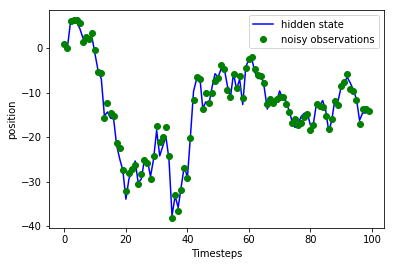

In [141]:
t, Z, Y, X = double_kalmin(mu_z = 5)
plt.plot(t, Y, "b", label = "hidden state")
plt.plot(t, X, "go", label = "noisy observations")
plt.xlabel("Timesteps")
plt.ylabel("position")
plt.legend()
plt.show()